In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle5 as pickle
import glob
from collections import defaultdict

ModuleNotFoundError: No module named 'pickle5'

In [56]:
def display_densiy(file, title, output_path=None, diaplay_legend=False):
    df = pickle.load(file)
    # REmove NaN values
    df = df.dropna()
    image_names = np.unique(df['image'] )

    # compute the average cell density
    densities=defaultdict(list)

    for image in image_names:
        image_data = df[df['image']==image].to_numpy()[:,[1,2]]
        for depth, value  in zip(image_data[:,0],image_data[:,1]):
            densities[depth].append(value)


    average={}
    median={}
    for key, value in densities.items():
        average[key] = np.average(value)
        median[key] = np.median(value)

    plt.figure(figsize=(10,10))
    for image in image_names:
        image_data = df[df['image']==image].to_numpy()[:,[0,1,2]]
        plt.plot(image_data[:,2], image_data[:,1],label=np.unique(image_data[:,0]))
        
    plt.plot(list(average.values()), list(average.keys()), linewidth=5, c='y', label='average values')
    plt.plot(list(median.values()),list(median.keys()), linewidth=5, c='black', label='median values')
    plt.title(f'{title} Cell density as a function of SSCX region percentage of depth.')
    plt.gca().set_ylabel("SSCX region percentage of depth")
    plt.gca().set_xlabel("Cell density cells/mm3")
    plt.gca().invert_yaxis()

    if diaplay_legend:
        lgnd = plt.legend(loc="upper left", scatterpoints=1, fontsize=10)
        for i in range(1):
            lgnd.legendHandles[i]._sizes = [5]
            lgnd.legendHandles[i]._alpha = 1 

    
    if output_path:
        plt.savefig(output_path + '/' + title + '_cell_density.png')


In [57]:
#file_list = [('../../../Production/Results/01413827_LH/1690967717.pkl', '01413827_LH')]

path_list = glob.glob("../../../Production/Results/*/1690967717.pkl")
file_list = []

for path in path_list:
    title = path[path.find('Results/')+len('Results/'):path.find('1690967717')-1]
    file_list.append([path, title])

    


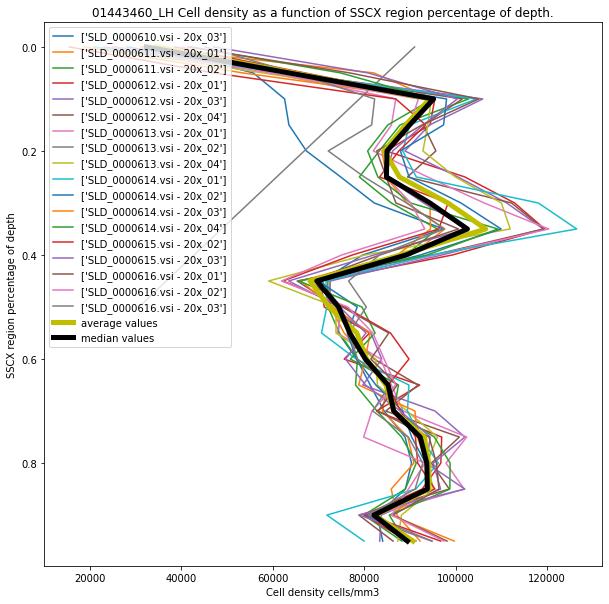

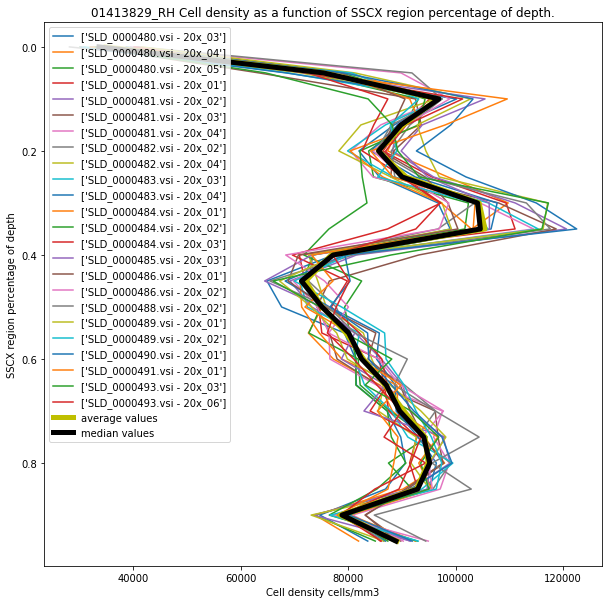

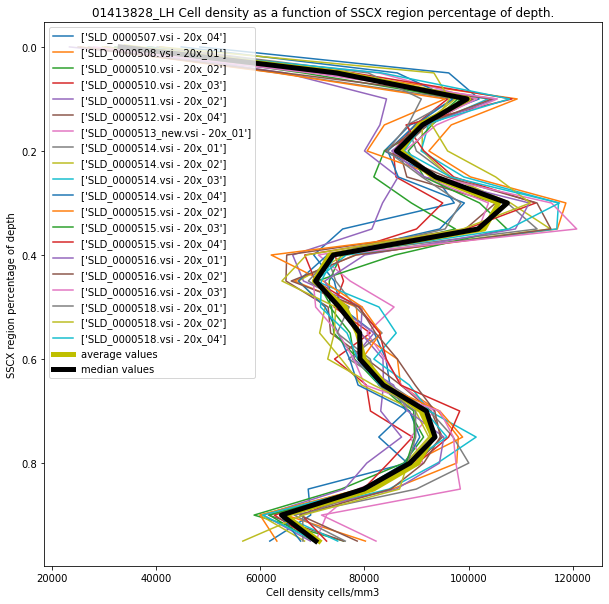

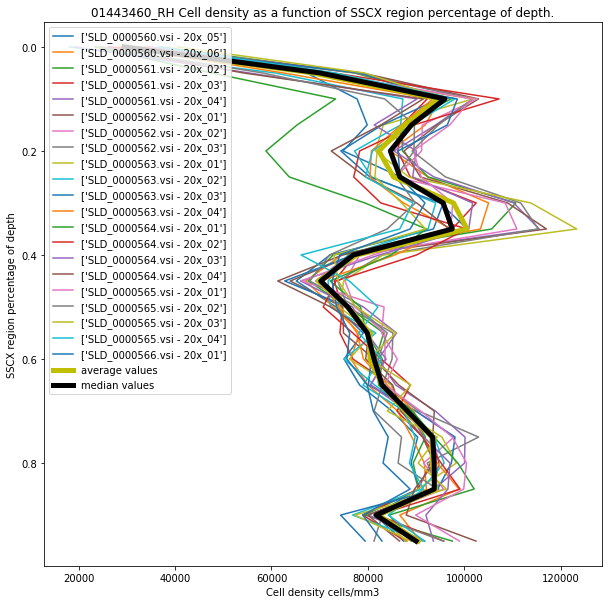

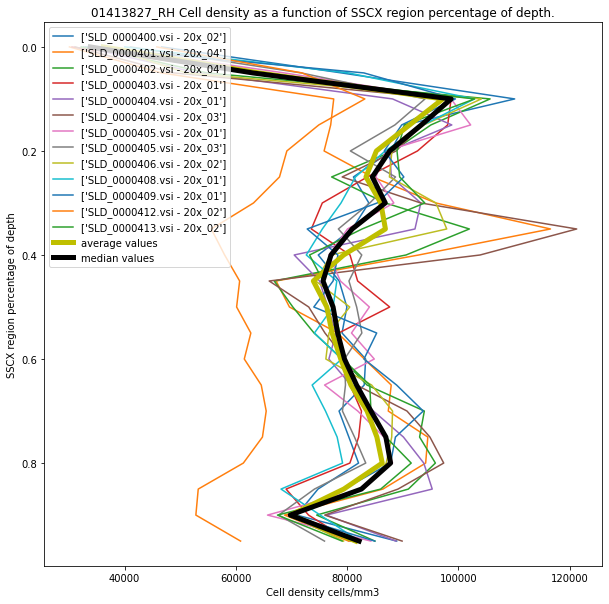

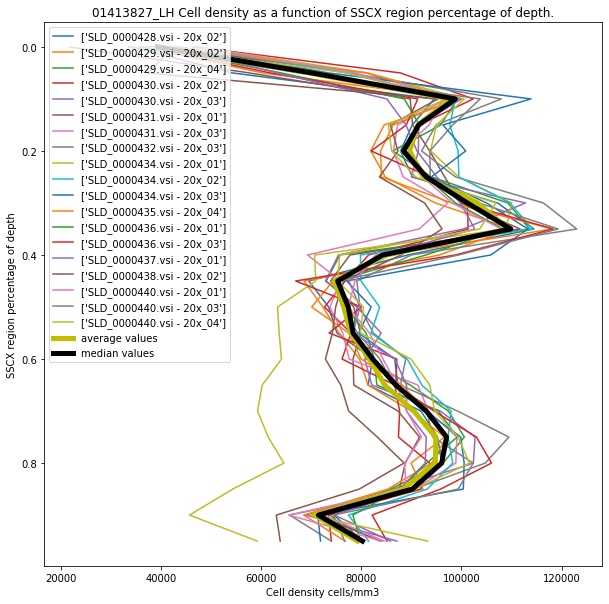

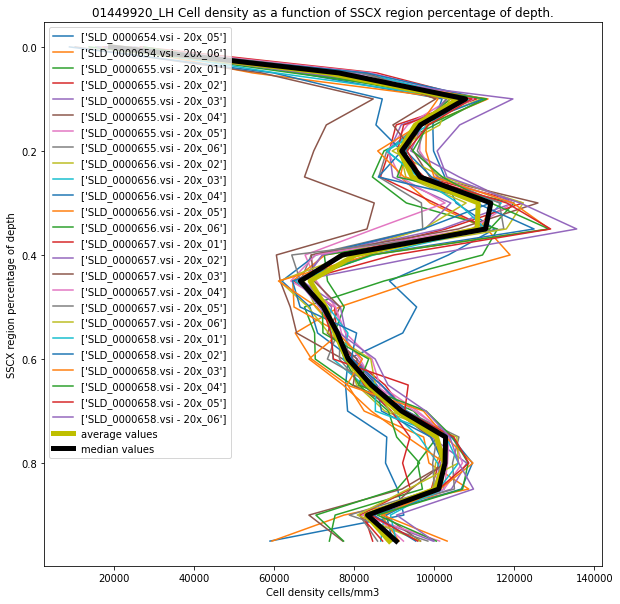

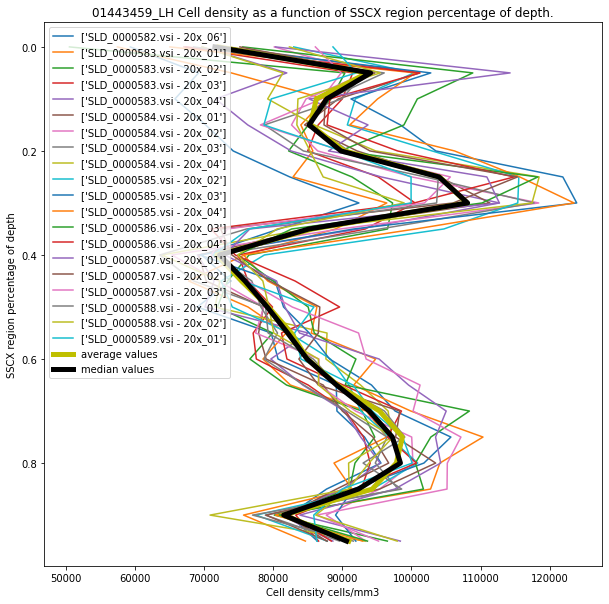

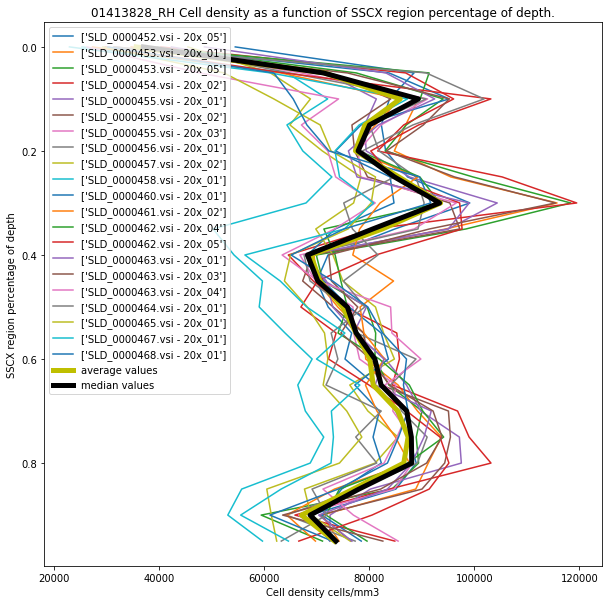

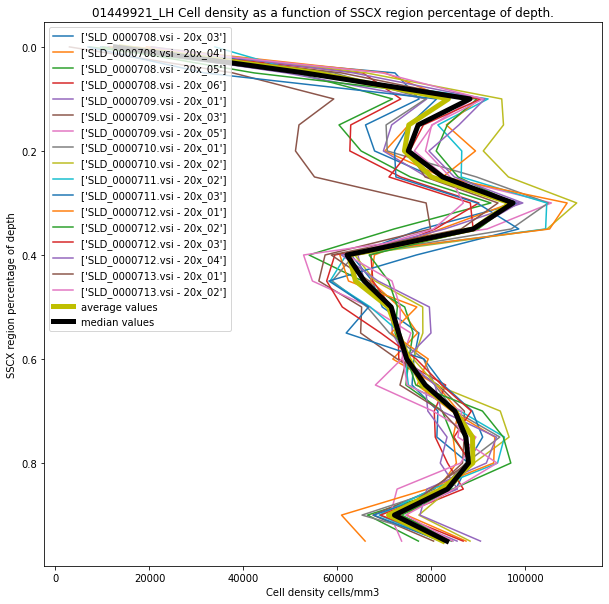

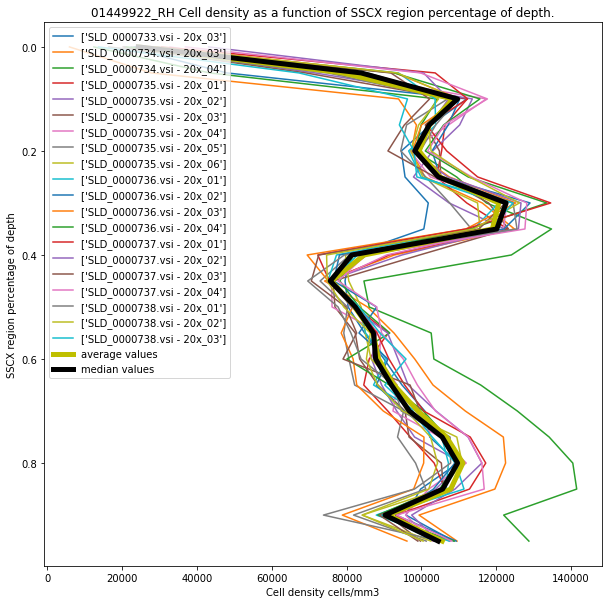

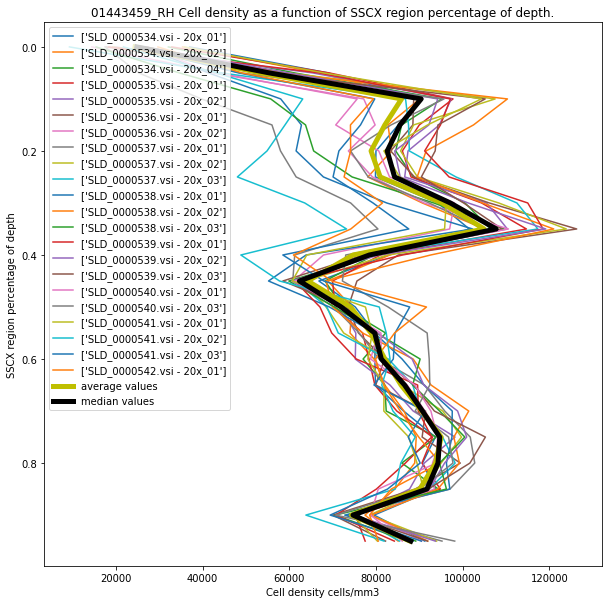

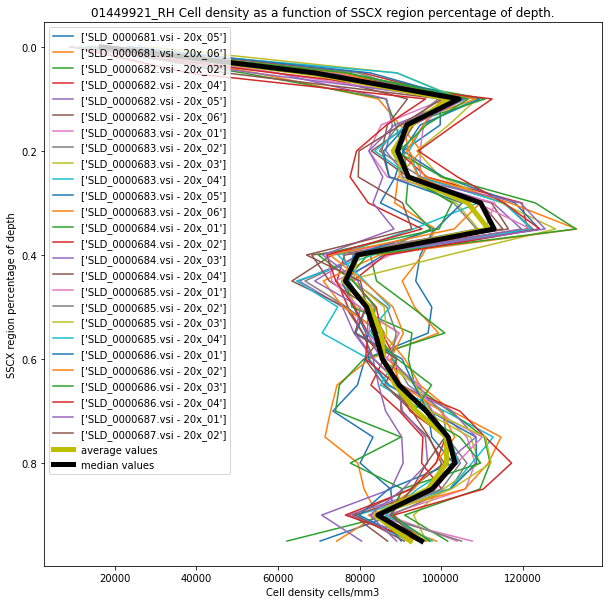

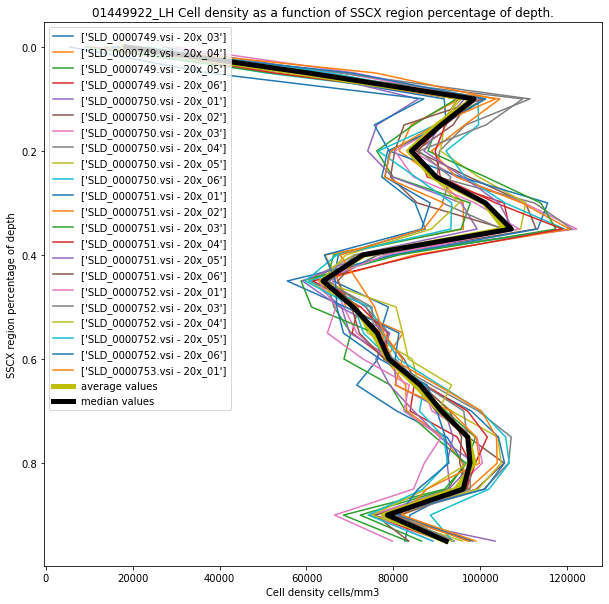

In [61]:
for filename, title in file_list:
    file = open(filename, 'rb') 
    #display_densiy(file, title, output_path="../../../Production/Results/plots/", diaplay_legend=True)
    display_densiy(file, title, diaplay_legend=True)

In [77]:
df = pd.read_pickle('../../../Production/Results/01443460_LH/1690967717.pkl')


'\n\nfor i in range(1):\n    lgnd.legendHandles[i]._sizes = [30]\n    lgnd.legendHandles[i]._alpha = 1 \n'

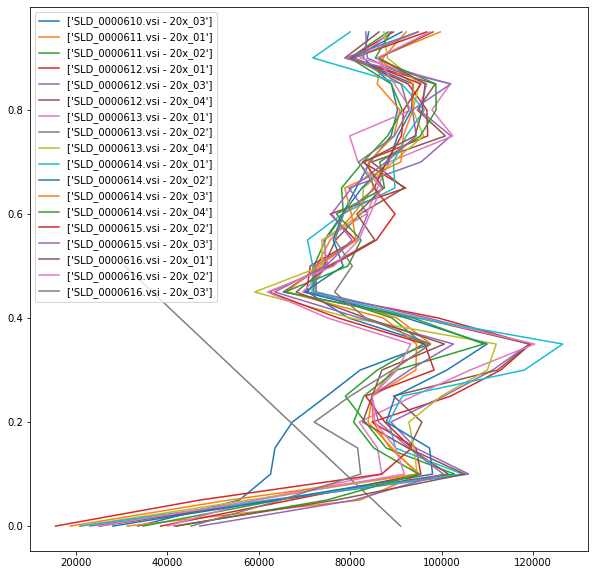

In [50]:
df = df.dropna()
image_names = np.unique(df['image'] )

# compute the average cell density
densities=defaultdict(list)

for image in image_names:
    image_data = df[df['image']==image].to_numpy()[:,[1,2]]
    for depth, value  in zip(image_data[:,0],image_data[:,1]):
        densities[depth].append(value)


average={}
median={}
for key, value in densities.items():
    average[key] = np.average(value)
    median[key] = np.median(value)

plt.figure(figsize=(10,10))
for image in image_names:
    image_data = df[df['image']==image].to_numpy()[:,[0,1,2]]
    plt.plot(image_data[:,2], image_data[:,1], label=np.unique(image_data[:,0]))
    
    

lgnd = plt.legend(loc="upper left", scatterpoints=1, fontsize=10)
'''

for i in range(1):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd.legendHandles[i]._alpha = 1 
'''

In [87]:
df_one = df[df.image == 'SLD_0000613.vsi - 20x_02' ]
image_data = df_one.to_numpy()[:,[1,2]]

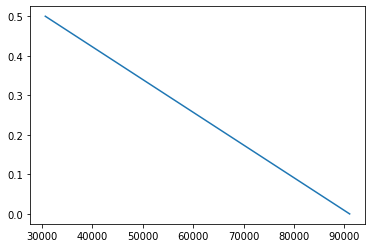

In [88]:
plt.plot(image_data[:,1], image_data[:,0])

In [89]:
image_data

array([[0.0, 91031.82770162917],
       [0.5, 30705.27376931966]], dtype=object)